In [1]:
#to run code in google colab
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
#import libararies 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pylab
%matplotlib inline

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras import models, layers
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Model
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, Dropout

In [4]:
#setting seeds for reproducibility
seed = 232
np.random.seed(seed)
tf.random.set_seed(seed)

In [5]:
# paths of dataset 
train_path = "/content/drive/MyDrive/chest_xray1/chest_xray1/Train"
val_path = "/content/drive/MyDrive/chest_xray1/chest_xray1/Val"
test_path="/content/drive/MyDrive/chest_xray1/chest_xray1/Test"

In [6]:
#loads images from specific directories, resizes them to a uniform size, shuffles them 
BATCH_SIZE = 64
IMAGE_SIZE = 224

train_data = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/chest_xray1/chest_xray1/Train",

    shuffle = True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)



test_data = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/chest_xray1/chest_xray1/Test",
    shuffle = True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)


val_data = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/chest_xray1/chest_xray1/Val",
    shuffle = True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)


Found 3900 files belonging to 3 classes.
Found 300 files belonging to 3 classes.
Found 279 files belonging to 3 classes.


In [8]:
# labels in every class 
labels_names = train_data.class_names
labels_names

['Normal', 'bacteria', 'virus']

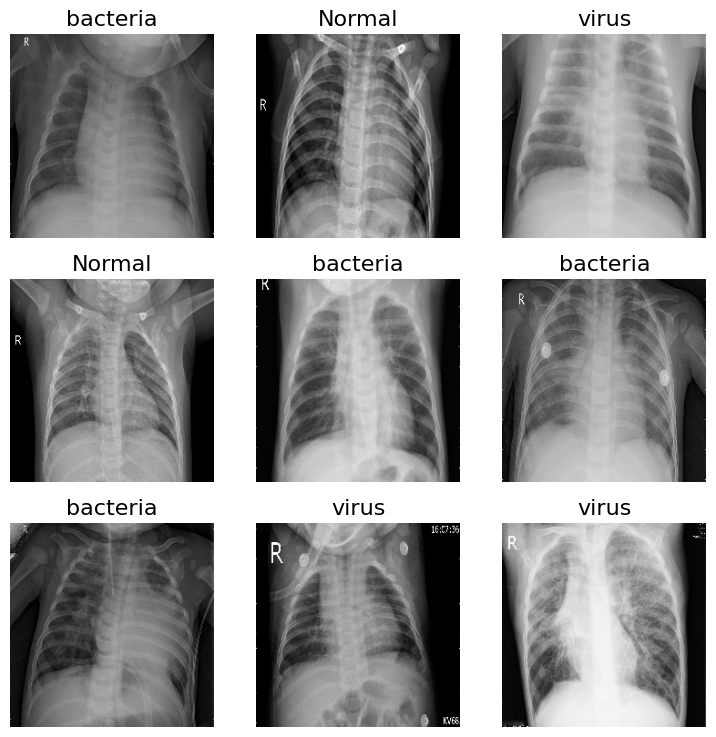

In [9]:
plt.figure(figsize = (9,9))
for image_batch, label_batch in train_data.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(labels_names[label_batch[i]],fontsize =16)
        plt.axis("off")


Models
 VGG

In [10]:
#VGG
from keras.applications.vgg16 import VGG16
tf.keras.backend.clear_session()
vgg_model = VGG16(weights = "imagenet", include_top=False,
 input_shape = (224,224, 3))

58889256/58889256 [==============================] - 0s 0us/step


In [12]:
for layer in vgg_model.layers:
  layer.trainable = False

In [13]:
vgg_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [17]:
vgg_model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics = ['accuracy']
)

In [18]:
#ResNet50
ResNet = ResNet50(include_top=False, weights='imagenet', input_shape=(IMAGE_SIZE,IMAGE_SIZE,3),pooling='max')
output = ResNet.layers[-1].output
output = tf.keras.layers.Flatten()(output)
ResNet = Model(ResNet.input, output)
res_name = []
for layer in ResNet.layers:
    res_name.append(layer.name)

In [19]:
set_trainable = False
for layer in ResNet.layers:
    if layer.name in res_name[-22:]:
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [23]:
ResNet.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_3[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                        

In [24]:
train_data = train_data.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_data = val_data.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_data = test_data.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [25]:
data_augmentation = tf.keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical",
                                                 input_shape=(IMAGE_SIZE,
                                                              IMAGE_SIZE,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.12),
    layers.experimental.preprocessing.RandomZoom(0.2),
  ]
)


Build model

In [27]:
#CNN
num_classes=len(labels_names)
model = Sequential()
model.add(ResNet)
model.add(Dense(2048, activation='relu'))
# model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
#model.add(Dense(64, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(128, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_1 (Functional)        (None, 2048)              23587712  
                                                                 
 dense_5 (Dense)             (None, 2048)              4196352   
                                                                 
 dropout_2 (Dropout)         (None, 2048)              0         
                                                                 
 dense_6 (Dense)             (None, 512)               1049088   
                                                                 
 dropout_3 (Dropout)         (None, 512)               0         
                                                                 
 dense_7 (Dense)             (None, 128)               65664     
                                                                 
 dense_8 (Dense)             (None, 3)                

In [28]:
#Creating model and compiling
model.compile(optimizer = tf.keras.optimizers.Adam(),

              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [29]:
epochs =10
history = model.fit(
    train_data,
    epochs = epochs,
    batch_size = BATCH_SIZE,
    validation_data = test_data,
    verbose = 1,
)

Epoch 1/10
61/61 [==============================] - 381s 1s/step - loss: 2.6126 - accuracy: 0.6018 - val_loss: 2.3439 - val_accuracy: 0.6633
Epoch 2/10
61/61 [==============================] - 15s 247ms/step - loss: 0.5795 - accuracy: 0.7385 - val_loss: 0.5377 - val_accuracy: 0.7567
Epoch 3/10
61/61 [==============================] - 16s 258ms/step - loss: 0.4725 - accuracy: 0.7887 - val_loss: 0.4772 - val_accuracy: 0.7800
Epoch 4/10
61/61 [==============================] - 16s 257ms/step - loss: 0.4097 - accuracy: 0.8172 - val_loss: 0.6297 - val_accuracy: 0.7500
Epoch 5/10
61/61 [==============================] - 15s 244ms/step - loss: 0.3424 - accuracy: 0.8551 - val_loss: 0.6346 - val_accuracy: 0.7467
Epoch 6/10
61/61 [==============================] - 15s 239ms/step - loss: 0.2848 - accuracy: 0.8833 - val_loss: 0.7556 - val_accuracy: 0.7633
Epoch 7/10
61/61 [==============================] - 15s 249ms/step - loss: 0.2203 - accuracy: 0.9136 - val_loss: 0.5186 - val_accuracy: 0.7900
E

In [30]:
scores = model.evaluate(train_data)
scores = model.evaluate(test_data)
scores = model.evaluate(val_data)

5/5 [==============================] - 39s 193ms/step - loss: 0.7310 - accuracy: 0.8065


first image 
actual value: bacteria
2/2 [==============================] - 0s 127ms/step
predicted value: bacteria


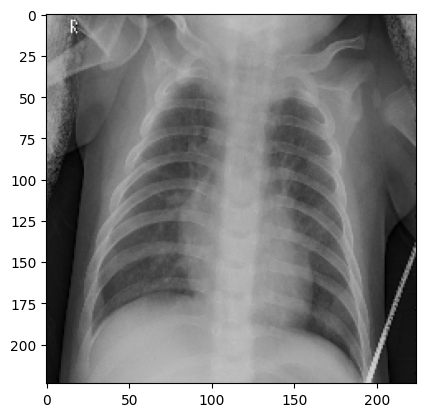

In [54]:
#evaluates one image from the validation 
for images_batch, labels_batch in val_data.take(1):

    first_image = images_batch[23].numpy().astype('uint8')
    first_label = labels_batch[25].numpy()

    print("first image ")
    plt.imshow(first_image)
    print("actual value:",labels_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted value:",labels_names[np.argmax(batch_prediction[23])])

In [33]:
#pridection model
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = labels_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 23ms/step


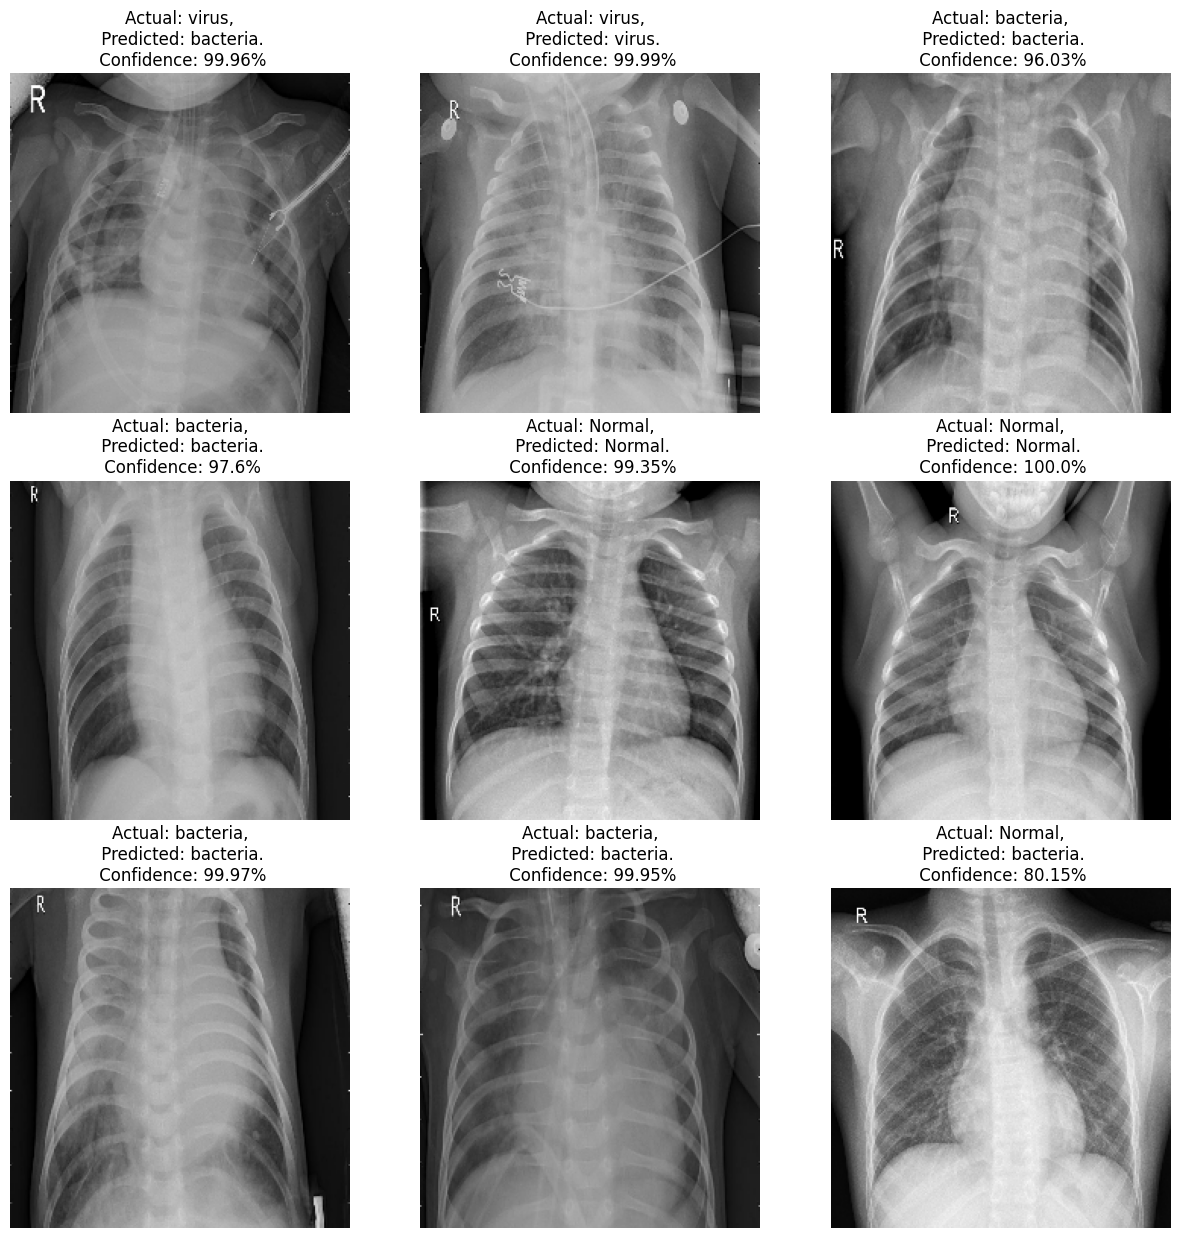

In [57]:
plt.figure(figsize=(15, 15))
for images, labels in val_data.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = labels_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

In [58]:
model.save('Pneumonia1 model .h5')

In [59]:
model.save('Pneumonia1 model.keras')

In [60]:
model.save('/content/drive/MyDrive/Pneumonia1 model.keras')

In [62]:
model.save('/content/drive/MyDrive/Pneumonia1 model.h5')

In [ ]:
# to deploy model in hugging face
 
#from huggingface_hub import HfApi

#api = HfApi()  
#api.upload_folder(
 #   folder_path="/kaggle/working/",
  #  repo_id="Eman90/demo",
  #  repo_type ="model",
#)